## 1- **Installation et importation**

---


In [ ]:
!python -m spacy download fr_core_news_sm
#importer le vocabulaire français
import spacy
nlp = spacy.load("fr_core_news_sm")

## 2- **Importer les fichiers**

---



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 ## 3- **Traitement des données**

---



In [2]:
import pandas as pd
#lire les données avec pandas
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/donnees.txt', sep="\t", header = None, names = ['id','tweet','date','end'])
data = pd.read_fwf('/content/drive/MyDrive/Colab Notebooks/donnees.txt')
data.columns = ['twt','nan']
data[['id2','tweet','date','end']] = data.twt.str.split("\t",expand=True)
#print(data['tweet'][0])
#print(data['date'][0])
#print(data['end'][0])
#print(data['nan'][0])
#après vérification ces deux colonnes ne nous sont pas d'une grande utilité elle sont vides

print(data['tweet'].head())


0    https://t.co/Cy7On2h564 Je commence à stream! ...
1                  je veux encore pleins de casquettes
2    "Je me suis trompé et je me tromperai encore"....
3    qu'Allah nous écarte de la mauvaise fréquentation
4                                              Meufff😻
Name: tweet, dtype: object


In [3]:
data.drop(columns=['end', 'nan'], inplace=True)

In [4]:
print(data.shape)

(100001, 4)


In [5]:
#isoler les tweets
s = data['tweet']
print(s)

0         https://t.co/Cy7On2h564 Je commence à stream! ...
1                       je veux encore pleins de casquettes
2         "Je me suis trompé et je me tromperai encore"....
3         qu'Allah nous écarte de la mauvaise fréquentation
4                                                   Meufff😻
                                ...                        
99996     Dites vous qu’ils y a des gens qui disent à le...
99997         Du Dinos pour l’hiver https://t.co/2j1dj19ZIL
99998             mon gars tes bzr t'es pas content tu swip
99999     Oui oui, on a compris votre vision de la démoc...
100000    Appel à manifester pour les 3 ans du mouvement...
Name: tweet, Length: 100001, dtype: object


## 4 - **Preprocessing** 

---



A - **récupérer la liste des stopwords français**

In [6]:
%%time
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
stop_words = list(fr_stop)


CPU times: user 61 µs, sys: 0 ns, total: 61 µs
Wall time: 73.7 µs


In [14]:
#le nom du fichier contenant la stoplist
stoplist = "/content/drive/MyDrive/Colab Notebooks/stopW.txt"

In [15]:
#créer une stopwords en la fusionnant avec celle de spacy
with open(stoplist, "r") as f:
    stopwords = f.read().splitlines()

stopwords.append(x for x in stop_words)

print(len(stopwords))

626


B- **tokenisation nettoyage et lemmatisation de chaque tweets**

In [8]:
import random
random.seed(3)
list_data= data['tweet'].values.tolist()
#on travaille avec un échantillon de 5000 tweets
raw_sample = random.sample(list_data, 5000)
print(raw_sample[3])

Meme si je suis pas très « fan » de Puma , on va pas se laisser vaincre par le Milan AC 😌#TeamOMAllez l’OM 💙⭐️ https://t.co/2BCFKqCVuF


In [9]:
%%time


#transformer les tweets en objet spacy
docs = list(nlp.pipe(raw_sample))

CPU times: user 31 s, sys: 611 ms, total: 31.7 s
Wall time: 31.7 s


In [10]:
#tokeniser et lemmatiser l'ensemble des tweets
""" -enlever la ponctuation,
    - enlever les espaces
    -enlever les email
    -enlever les urls
    -enlever les mots de moins de 3 caractères"""
tokenized_lemmatized_texts_brut = [[token.lemma_.lower() for token in doc 
                               if not token.is_punct and not 
                               token.is_space and not 
                               token.like_url and not 
                               token.like_email and 
                               token.tag_!= 'Num' ] for doc in docs]


In [29]:
#Deuxième passe de nettoyage
def clean(msg):
    clean_msg = []
    for word in msg:
        #Supprimer tout ce qui n'est pas des lettres
        clean_word = re.sub(r'\W', '', word)
        #Supprimer les chiffres
        clean_word = re.sub(r'\d', '', clean_word)
        if clean_word not in stopwords and clean_word != '' : # enlever les mots vide
            clean_msg.append(clean_word)
    return clean_msg

In [12]:
len(tokenized_lemmatized_texts_brut)

5000

In [30]:
%%time
import re
tokenized_lemmatized_texts = []

#Nettoyage des tweets
for msg in tokenized_lemmatized_texts_brut:
    tokenized_lemmatized_texts.append(clean(msg)) 

CPU times: user 1 s, sys: 6.53 ms, total: 1.01 s
Wall time: 1.01 s


À voir comment élargir la stopwords afin de garder des mots significatifs(abréviations) largement utilisés sur les réseau sociaux et relatifs à la haine (ex : pd, fdp etc...)

In [32]:
#vérifier le résultats
#print(tokenized_lemmatized_texts)

In [18]:
cleaned_tweet= list(tokenized_lemmatized_texts)

for i in range(len(cleaned_tweet)):
    cleaned_tweet[i] = ' '.join(cleaned_tweet[i])

## 5 - **Analyse des données**

In [19]:
#Examiner la longueur en caractères de chaque tweet 
data['pre_clean_longueur'] = [len(t) for t in data.tweet]
print(data.pre_clean_longueur)

0         120
1          35
2         100
3          49
4           7
         ... 
99996     204
99997      45
99998      41
99999      52
100000    107
Name: pre_clean_longueur, Length: 100001, dtype: int64


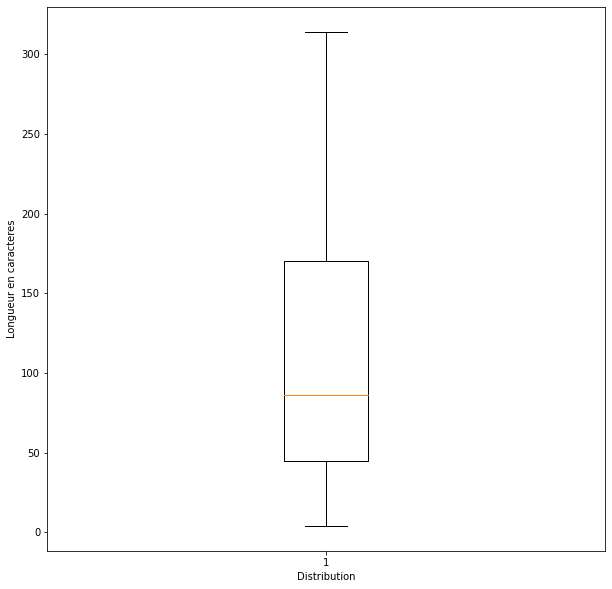

In [20]:
import matplotlib.pyplot as plt 
#Boxplot illustrant la longueur des tweets afin de vérifier s'ils respectent la limite de caractères. 
plt.boxplot(data.pre_clean_longueur)
ax.set_xlabel('Distribution')
ax.set_ylabel('Longueur en caracteres')
plt.show()

Les tweets sont de longueurs homogènes , la majorité fluctue entre 40 et 170 caractères avec une moyenne de 80 caractères.

In [21]:
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud

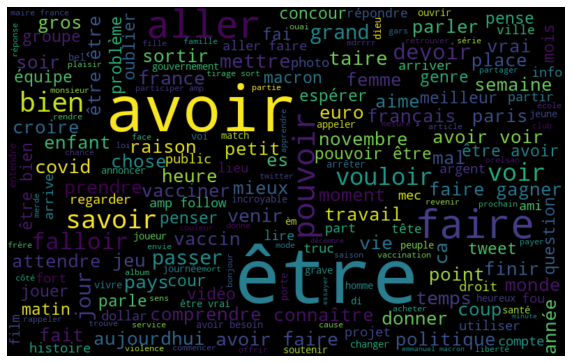

In [22]:
all_words = ' '.join([text for text in cleaned_tweet])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

En prenant le dataset et après nettoyage et preprocessing , on retrouve les verbes être et avoir entre autres verbes très utilisé en français en tête de liste dans le nuage de mots.